# Multiview Rendering

This notebook demonstrates how to solve the Radiative Transfer using SHDOM and render multiview images. 

The images rendered are monochromatic- a single wavelength for which a mie table was previously calculated.

---

Related tutorials: 
 - Make Mie Table.ipynb - how to create mie tables
 - Radiance Rendering [Single Image].ipynb - how to create a single monochromatic image
 - Radiance Rendering [Multispectral].ipynb - how to create RGB (multispectral) images

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shdom

In [2]:
""" 
 - MiePolydisperse object loads a previously saved mie table.
 - Rayleigh object initilizes Rayleigh scattering according to a temperature profile.
   Temperature profile here is of summer mid-latitude for 0-20km taken from AFGL [1]
 - A Large-Eddy-Simulated [2] cloud michrophysical properties are loaded from a csv file.

[1] G. P. Anderson, S. A. Clough, F. Kneizys, J. H. Chetwynd, and E. P. Shettle. 
    AFGL atmospheric constituentprofiles (0.120 km). Technical report, Air Force Geophysics Lab, 1986.
[2] G. Matheou and D. Chung. Large-eddy simulation of stratified turbulence. 
    part CLARREO: Application of thestretched-vortex model to the atmospheric boundary layer.
    Journal of the Atmospheric Sciences, 71(12):44394460,2014.
"""
# Mie scattering for water droplets
mie = shdom.MiePolydisperse()
mie.read_table(file_path='../mie_tables/polydisperse/Water_672nm.scat')

# Generate a Microphysical medium
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico32x37x26.txt', veff=0.1)
droplets.add_mie(mie)

# Rayleigh scattering for air molecules up to 20 km
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))
rayleigh = shdom.Rayleigh(wavelength=0.672)
rayleigh.set_profile(temperature_profile.resample(air_grid))
air = rayleigh.get_scatterer()

Reading mie table from file: ../mie_tables/polydisperse/Water_672nm.scat


In [3]:
"""
Generate an Medium with two type of scatterers and initilize an RteSolver object. 
This will initialize all of shdom internal structures and grids.

SceneParameters() contains parameters such as surface albedo and solar radiance
NumericalParameters() contains parameters such as number of angular bins and split cell ratio.
All parameters have default values which can be viewed using print(params.info).
"""
atmospheric_grid = droplets.grid + air.grid
atmosphere = shdom.Medium(atmospheric_grid)
atmosphere.add_scatterer(droplets, name='cloud')
atmosphere.add_scatterer(air, name='air')

numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=mie.wavelength,
    source=shdom.SolarSource(azimuth=65, zenith=135)
)

rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.set_medium(atmosphere)

print(rte_solver.info)

Scene Parameters: 
   Wavelength: [0.672 micron]
   Surface: [Lambertian, albedo: 0.05]
   Source: [Solar, flux: 1.0, azimuth: 65deg, zenith: 135deg]
   Boundary Conditions: [x:open, y:open]

Numerical Parameters: 
   num_mu_bins: 8
   num_phi_bins: 16
   split_accuracy: 0.1
   deltam: True
   spherical_harmonics_accuracy: 0.01
   solution_accuracy: 0.0001
   acceleration_flag: True
   max_total_mb: 10000.0
   adapt_grid_factor: 5
   num_sh_term_factor: 5
   cell_to_point_ratio: 1.5
   high_order_radiance: True



In [4]:
"""
Solve the Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (src/unpolarized/shdomsub1.f).
The outputs are the source function (J) and radiance field (I) which are stored in 
the shdom.RteSolver object. These are subsequently used for the rendering of an image.
"""
rte_solver.solve(maxiter=100)

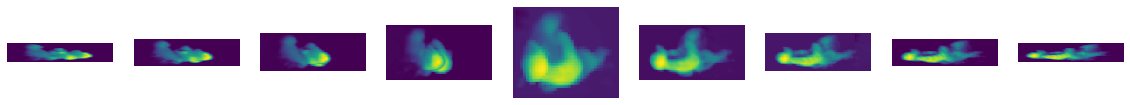

In [5]:
"""
Define a sensor array and render multi-view images of the domain. 
Note that in some cases of small atmospheric domain, parallel rendering is slower due to comunication overhead.
Plot the synthetic images.
"""
# A fly over from East to West (negative y-axis direction)
zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
azimuth_list = [90, 90, 90, 90, 0, -90, -90, -90, -90]

projection = shdom.MultiViewProjection()

for zenith, azimuth in zip(zenith_list, azimuth_list):
    projection.add_projection(
        shdom.OrthographicProjection(
            bounding_box=droplets.grid.bounding_box, 
            x_resolution=0.01, 
            y_resolution=0.01, 
            azimuth=azimuth, 
            zenith=zenith,
            altitude='TOA'
        )
    )
    
camera = shdom.Camera(shdom.RadianceSensor(), projection)
images = camera.render(rte_solver, n_jobs=40)

%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
for ax, image in zip(axarr, images):
    ax.imshow(image)
    ax.invert_xaxis() 
    ax.invert_yaxis() 
    ax.axis('off')